# HPLC-py: A Python Utility For Rapid Quantification of Complex Chemical Chromatograms

* https://github.com/cremerlab/hplc-py/tree/main

* https://joss.theoj.org/papers/10.21105/joss.06270

High-Performance Liquid Chromatography (HPLC) is an analytical technique which allows for quantitative characterization of the chemical components of a mixture. While many of the technical details of HPLC are now automated, the programmatic cleaning and processing of the resulting data often requires extensive manual labor. This package was developed to alleviate some of this burden, making the actual running of the HPLC the most time-consuming part of the quantification.

# Installation

You can install hplc-py on pip:

In [4]:
!pip install --upgrade hplc-py

Dependencies for hplc-py are as follows:

* Python 3.9 or newer

* NumPy

* SciPy

* Pandas

* Seaborn

* Tqdm

* Termcolor

# 0. Baseline Correction

##What’s in a baseline?

In liquid chromatographic analysis, compounds are carried through an absorptive substrate (termed a stationary phase) by a solvent (termed the mobile phase). In an ideal world, the column is saturated with the mobile phase and is held at a stable temperature and pressure. This sets baseline signal that can be subtracted from
the signal detected over the course of the chromatographic separation, allowing for quantitation.

However, we don’t live in a perfect world. Often, variations in the column temperature or ineffective equilibration of the column with the solvent, resulting in a drifting baseline. For complex samples, such as whole-cell metabolomic extracts, a drifting baseline may result from the sheer number of compounds present in the sample at low abundance that convolve to a “bumpy” baseline.

For quantitative analysis, we would like to correct for a drifting baseline, so we can more effectively tease out what signal is due to our compound of interest and what is due to nuisance. Take for example the following chromatogram with a known “true” drifting baseline.

In [5]:

# Download the raw CSV file into the data directory
!wget https://raw.githubusercontent.com/cremerlab/hplc-py/main/docs/source/methodology/data/sample_baseline.csv -P data

--2025-11-26 10:35:54--  https://raw.githubusercontent.com/cremerlab/hplc-py/main/docs/source/methodology/data/sample_baseline.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210109 (205K) [text/plain]
Saving to: ‘data/sample_baseline.csv.1’

sample_baseline.csv 100%[===================>] 205.18K  --.-KB/s    in 0.01s   

2025-11-26 10:35:54 (19.6 MB/s) - ‘data/sample_baseline.csv.1’ saved [210109/210109]



Text(0, 0.5, 'signal')

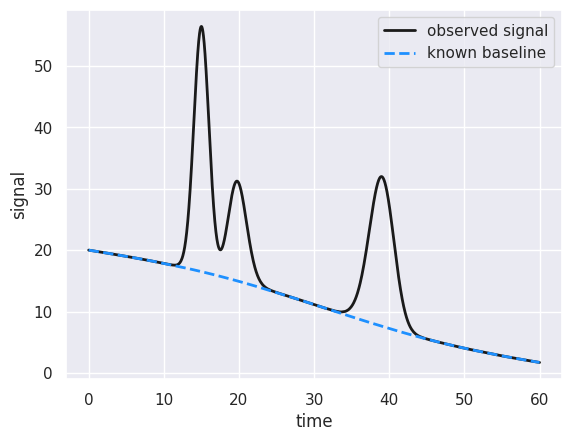

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load a dataset with a known drifting baseline
df = pd.read_csv('data/sample_baseline.csv')

# Plot the convolved signal and the known baseline
plt.plot(df['time'], df['signal'], '-', color='k', label='observed signal', lw=2)
plt.plot(df['time'], df['true_background'], '--', color='dodgerblue',
         label='known baseline', lw=2)
plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

This chromatogram was simulated as a mixture of three peaks with a known (large) drifting baseline (dashed blue line). But what if we don’t know what the baseline is?

##Subtraction using the SNIP algorithm

In reality, we don’t know this baseline, so we have to use clever filtering tricks to infer what this baseline signal may be and subtract it from our observed signal. There are many ways one can do this, ranging from fitting of polynomial functions to machine learning models and beyond. In hplc-py, we employ a method known as Statistical Non-linear Iterative Peak (SNIP) clipping. his is implemented in the hplc-py package as method correct_baseline to the Chromatogram class. The SNIP algorithm works as follows.

###Log-transformation of the signal

First, the dynamic range of the signal
 is reduced through the application of an LLS operator. This prevents enormous peaks from dominating the filtering, leading to the erasure of smaller (yet still important) peaks. Mathematically, the compression
 is achieved by computing

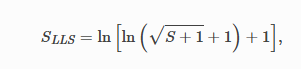

where the application of the square-root operator selectively enhances small peaks while the log operator compresses the signal across orders of magnitude. Applying this operator to signal in our simulated chromatogram yields the following

Text(0, 0.5, 'signal')

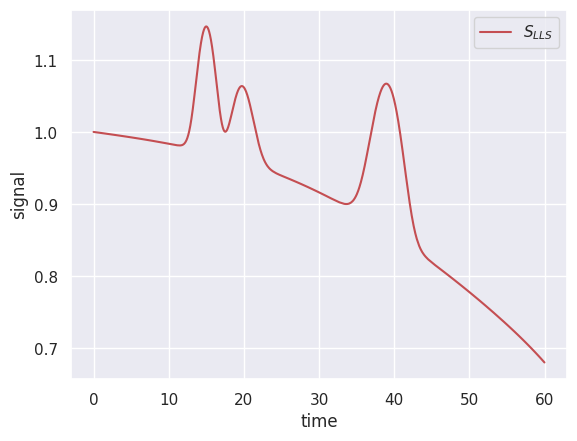

In [7]:
# Apply the LLS operator to the signal and visualize
import numpy as np
S = df['signal'].values
S_LLS = np.log(np.log(np.sqrt(S + 1) + 1) + 1)
plt.plot(df['time'], S_LLS, '-', color='r', label="$S_{LLS}$")
plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

Note that the y-axis has been compressed to a small range and that the first peak is now comparable in size to the other two peaks.

###Iterative Minimum Filtering

With a compressed signal, we can now apply a minimum filter over a given window of time
 over several iterations
. For each time point
 in the compressed signal, the filtered value
 for iteration
 is computed as

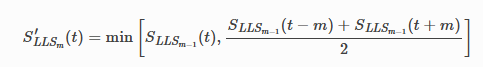

Note that the average value of the signal at time
 is compared to the average of the window boundaries, with the window increasing in size from one iteration to the next. To see this in action, we can plot the filtering result over the first 200 iterations of this procedure applied to the above compressed signal.

Text(0, 0.5, 'signal')

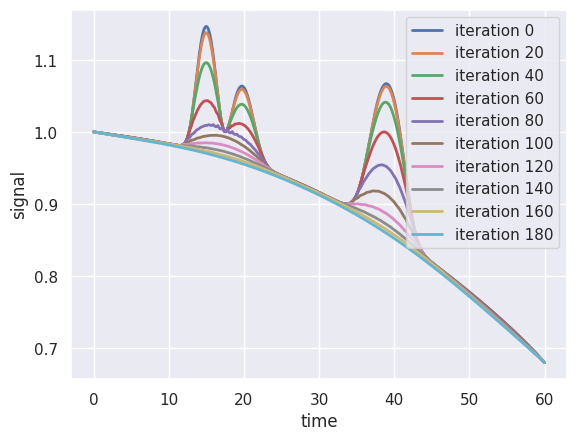

In [8]:
# Define a function to compute the minimum filter
def min_filt(S_LLS, m):
    """Applies the SNIP minimum filter defined in Eq. 2"""
    S_LLS_filt = np.copy(S_LLS)
    for i in range(m, len(S_LLS) - m):
        S_LLS_filt[i] = min(S_LLS[i], (S_LLS[i-m] + S_LLS[i + m])/2)
    return S_LLS_filt

# Apply the filter for the first 100 iterations and plot
S_LLS_filt = np.copy(S_LLS)
for m in range(200):
    S_LLS_filt = min_filt(S_LLS_filt, m)
    # Plot every ten iterations
    if (m % 20) == 0:
        plt.plot(df['time'], S_LLS_filt, '-', label=f'iteration {m}', lw=2)

plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

As the number of iterations increases in the above example, the actual peak signals become smaller and smaller, eventually approaching the baseline.

# Inverse Transformation and Subtraction

Once the signal has been filtered across
 iterations, the filtered signal
 can be passed through the inverse LLS operator to expand the dynamic range back to the scale of the observed data. This inverse operator, converting
 is defined as

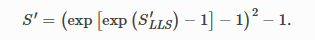

Performing the subtraction
 effectively removes the baseline signal leaving only the “true” signal

Text(0, 0.5, 'signal')

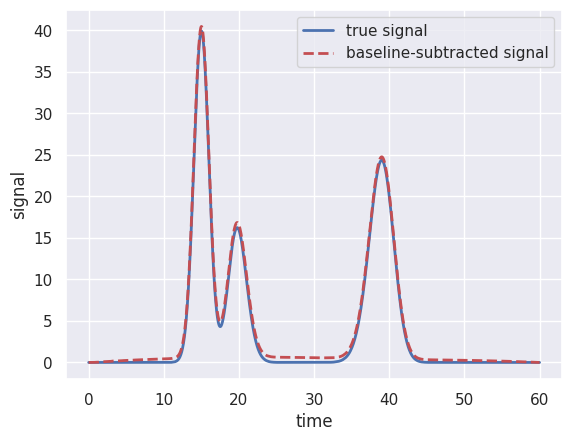

In [9]:
# Compute the inverse transform
S_prime = (np.exp(np.exp(S_LLS_filt) - 1) - 1)**2 - 1

# Perform the subtraction and plot the reconstructed signal over the known signal
S_subtracted = S - S_prime
plt.plot(df['time'], df['true_signal'], '-', lw=2, label='true signal')
plt.plot(df['time'], S_subtracted, '--', lw=2, color='r', label='baseline-subtracted signal')
plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

With 200 iterations of the filtering, the baseline-subtracted signal is almost exactly overlapping the known signal, demonstrating the power of the SNIP algorithm.

###How many iterations?

The above is dependent on how many iterations are run. As described by Morhác and Matousek (2008), a good rule of thumb for choosing the number of iterations
 is

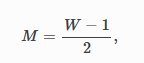

where
 is the typical width (in number of time points) of the preserved peaks. Choosing
 is dependent on your particular signal. In HPLC chromatograms, the observed peaks are typically on the order of a minute or two wide. In general, it’s advisable to be generous with the approximate peak widths as an underestimation can result in subtracting actual signal.

###Implementation in hplc-py

The above SNIP background subtraction algorithm is included as a method correct_baseline of a Chromatogram object. The above steps can be called in a few lines of code as in the following:

Performing baseline correction: 100%|██████████| 187/187 [00:01<00:00, 163.90it/s]


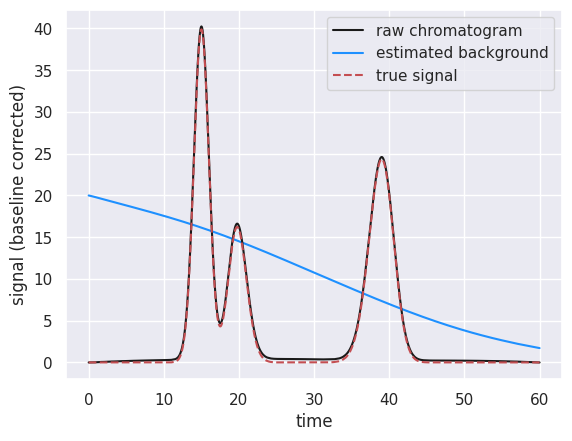

In [10]:
from hplc.quant import Chromatogram

# Load the dataframe as a chromatogram object
chrom = Chromatogram(df)

# Subtract the background given a peak width of ≈ 3 min
chrom.correct_baseline(window=3)

# Show the chromatogram
fig, ax = chrom.show()

# Plot the true signal
ax.plot(df['time'], df['true_signal'], 'r--', label='true signal')
ax.legend()

# 1. Loading and viewing chromatograms

In [11]:
# Please upload 'example (1).csv' manually.
from google.colab import files
uploaded = files.upload()

Saving chromatogram1.txt to chromatogram1.txt


Text files containing chromatograms with time and signal information can be intelligently read into a pandas DataFrame using hplc.io.load_chromatogram().

By providing the column names as a dictionary, you can rename the (often annoying) default column names to something easier to work with, such as “time” and “signal” as

In [12]:
# Load the chromatogram as a dataframe
from hplc.io import load_chromatogram

# Load the text file and rename the columns to standard names
# Mapping: 'R.Time (min)' -> 'time', 'Intensity' -> 'signal'
df = load_chromatogram('/content/chromatogram1.txt',
                       cols={'R.Time (min)': 'time', 'Intensity': 'signal'})
df.head()

,time,signal
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


This dataframe can now be loaded passed to the Chromatogram class, which has a variety of methods for quantification, cropping, and visualization and more.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

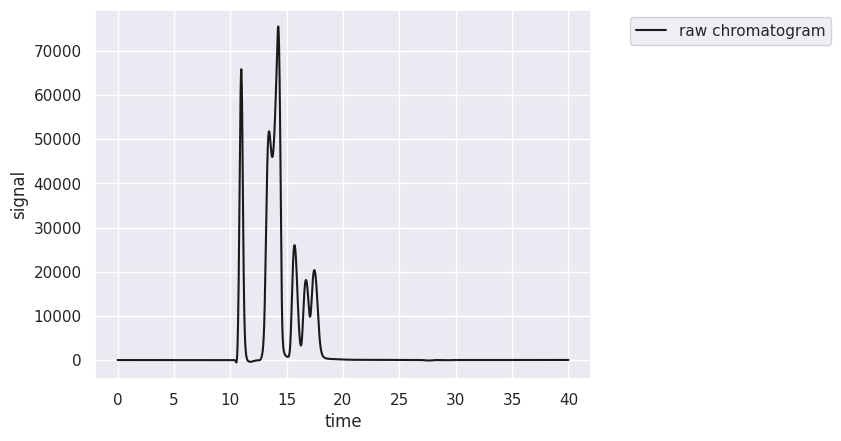

In [13]:
# Instantiate the Chromatogram class with the loaded chromatogram.
from hplc.quant import Chromatogram
chrom = Chromatogram(df)

# Show the chromatogram
chrom.show()

The crop method allows you to crop the chromatogram in place to restrict the signal to a specific time range.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

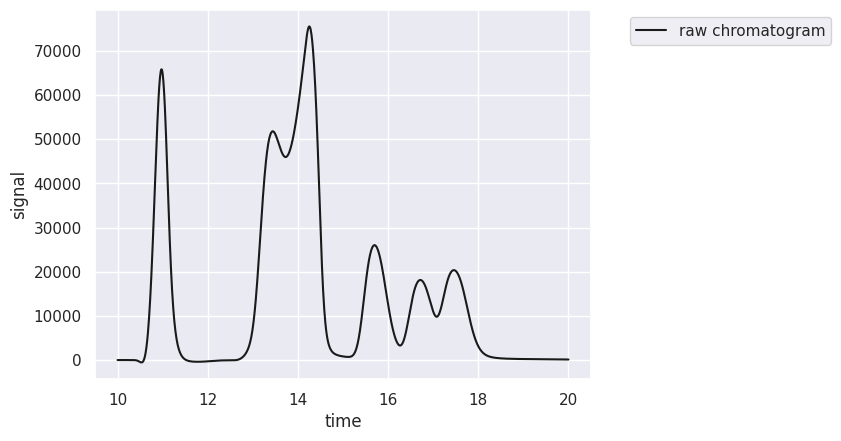

In [14]:
# Crop the chromatogram in place between 8 and 21 min.
chrom.crop([10, 20])
chrom.show()

Note that the crop function operates in place and modifies the loaded as data within the Chromatogram object.

# 2. Detecting and Fitting Peaks

## Selecting peaks by topographic prominence

Peaks are defined by a handful of quantitative properties. The most relevant to hplc-py is the topographic prominence, which is a measure of the relative height of a maxima in the signal to its nearest baseline. For chromatographic data, peaks are often highly pronounced relative to their surrounding signal, except in two limits:

The concentration of the analyte is close to the sensitivity limit of the detector

The peak overlaps with a nearby peak which is much higher in concentration, drowning out or completely subsuming the signal.

As an example, we can load a real chromatogram of a minimal medium for bacterial growth which has a slew of compounds, some of which overlap.

(10.0, 20.0)

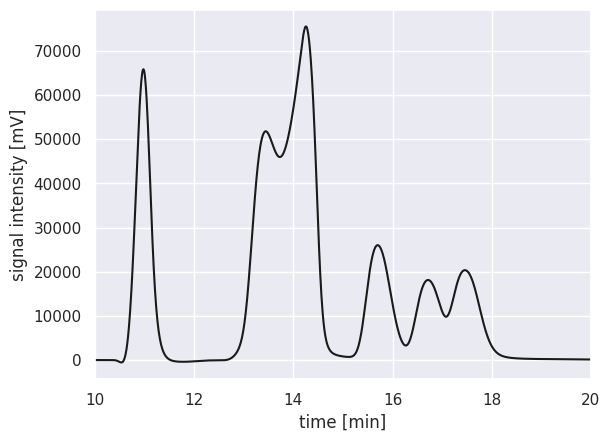

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hplc.io import load_chromatogram
sns.set()

# Load a sample chromatogram and show the trace, cropped between 10 and 20 minutes
# We use load_chromatogram to map the file's headers to 'time' and 'signal'
df = load_chromatogram('/content/chromatogram1.txt',
                       cols={'R.Time (min)': 'time', 'Intensity': 'signal'})

plt.plot(df['time'], df['signal'], 'k-')
plt.xlabel('time [min]')
plt.ylabel('signal intensity [mV]')
plt.xlim([10, 20])

With this signal, the location of peaks (meaning, the index where a local maxima is detected) can be identified using scipy.signal.find_peaks, even with a very low prominence filter. TO allow prominence filters to be comparable between chromatograms, we normalize the chromatogram first between 0 and 1.

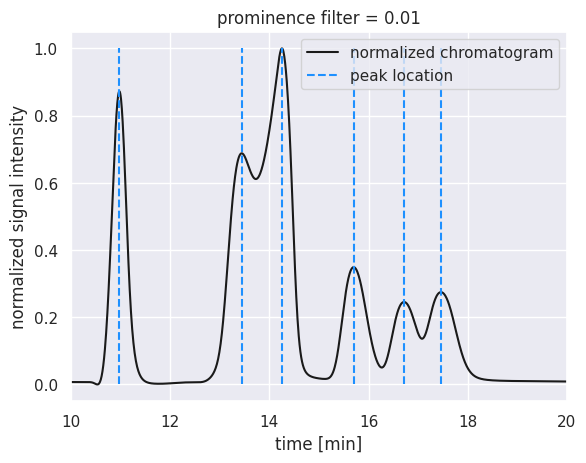

In [16]:
import scipy.signal

# Create a normalized signal using the correct column 'signal'
signal_norm = (df['signal'] - df['signal'].min()) / (df['signal'].max() - df['signal'].min())

# Find peaks with a low prominence filter of 0.01
peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=0.01)

# Plot the  original trace and overlay vertical lines with location of peaks
# Use correct column 'time'
plt.plot(df['time'], signal_norm, 'k-', label='normalized chromatogram')
plt.vlines(df['time'].values[peak_locations], 0, 1, linestyle='--',
           color='dodgerblue', label='peak location')
plt.xlabel('time [min]')
plt.ylabel('normalized signal intensity')
plt.xlim([10, 20])
plt.title('prominence filter = 0.01')
plt.legend()

These maxima have prominence values greater than or equal to 0.01, meaning that maxima with prominences as low as 0.01 units above the local background are considered to be bonafide peaks. Increasing the prominence filter begins to remove peaks we would otherwise care about.

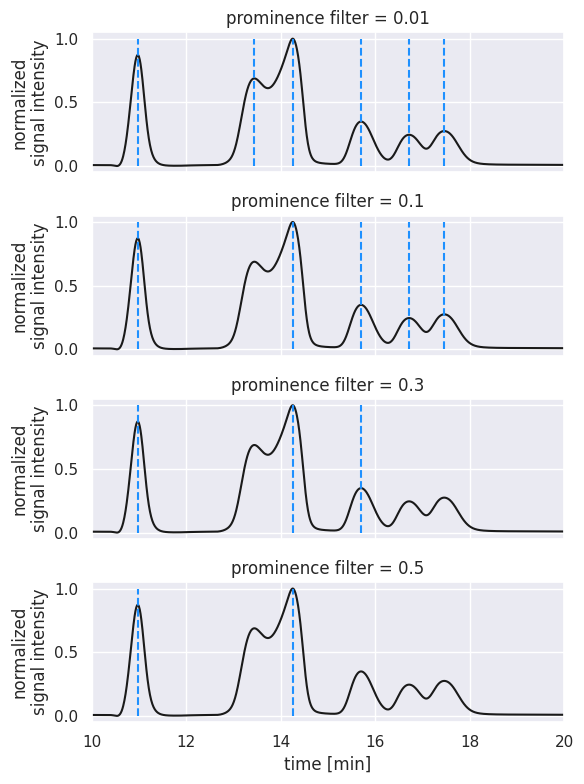

In [17]:
# Plot the  original trace and overlay vertical lines with location of peaks
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
for a in ax:
    # Use 'time' instead of 'time_min'
    a.plot(df['time'], signal_norm, 'k-')
    a.set_ylabel('normalized\nsignal intensity')

# Plot for a few prominecne values
for i, p in enumerate([0.01, 0.1, 0.3, 0.5]):
    peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=p)
    # Use 'time' instead of 'time_min'
    ax[i].vlines(df['time'].values[peak_locations], 0, 1, linestyle='--', color='dodgerblue')
    ax[i].set_title(f'prominence filter = {p}')

# Add necessary labels
ax[3].set_xlabel('time [min]')
ax[2].set_xlim([10, 20])
plt.tight_layout()

The choice of a prominence filter is going to be dependent on the size of peaks that you care to resolve in your chromatogram, their degree of overlap, and how noisy your signal is. The prominence filter can be passed as a keyword argument in the fit_peaks method of a Chromatogram. For example, passing a restrictive prominence filter of 0.1 can be done as follows:

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

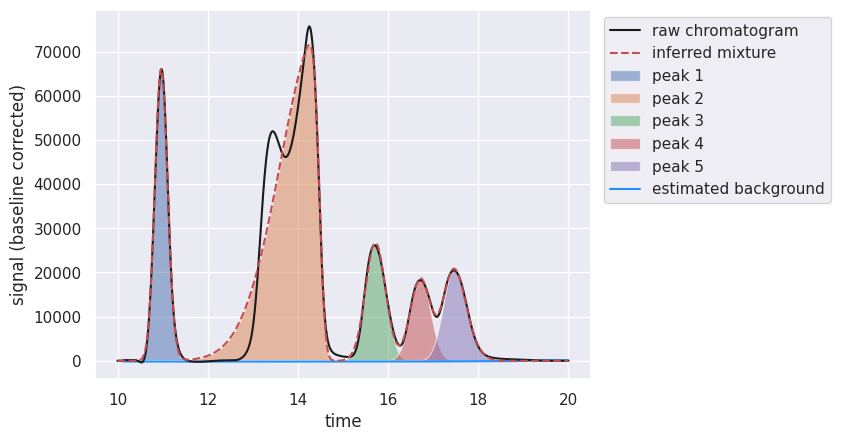

In [18]:
from hplc.quant import Chromatogram

# Load the signal trace as a Chromatogram object and crop between 10 and 20 min.
# Updated cols to match the DataFrame columns: 'time' and 'signal'
chrom = Chromatogram(df, cols={'time':'time', 'signal':'signal'},
                     time_window=[10, 20])

# Pass a prominence filter, fit the peaks, and show the result
peaks = chrom.fit_peaks(prominence=0.1)
chrom.show()

Note that even though the small peak at ≈ 13 minutes was not detected by the prominence filter, hplc-py still attempted to fit its signal as if it was part of the peak with a maximum at ≈ 14.2 min. This because the small peak was considered part of the same window of the major peak, as we will explore next.

##Clipping the signal into peak windows

Once peak maxima are identified, hplc-py slices the chromatograms into windows–regions of the chromatogram where peaks are overlapping or nearly overlapping. This is achieved by measuring the widths of each peak at the lowest contour line. Peaks which have overlapping contour lines are considered to be close enough that their signals may be influencing one another. This is achieved under the hood in a method _assign_peak_windows of a Chromatogram which is called as part of fit_peaks.

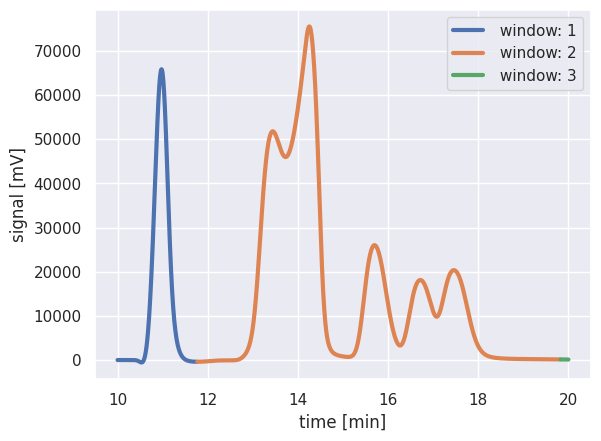

In [19]:
# Fit the peaks using a permissive prominence filter
window_df = chrom._assign_windows(prominence=0.01)

# Plot each window
for g, d in window_df.groupby('window_id'):
    # Use 'time' and 'signal' instead of 'time_min' and 'intensity_mV'
    plt.plot(d['time'], d['signal'], '-', lw=3, label=f' window: {g}')
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')

plt.legend()

Peaks within each colored region are considered to be interacting signals, and are fit together as one unit. In the above example, the peak at ≈ 11 min (in window 1) is considered to be isolated from the peaks at ≈ 13 min onward.

The extent of each peak window can be controlled by a buffer parameter passed to fit_peaks and _assign_windows. This, given in units of time points, extends each peak window on to account for nearby baseline signal. The above windows can be expanded by increasing this parameter, which has a default value of 0.

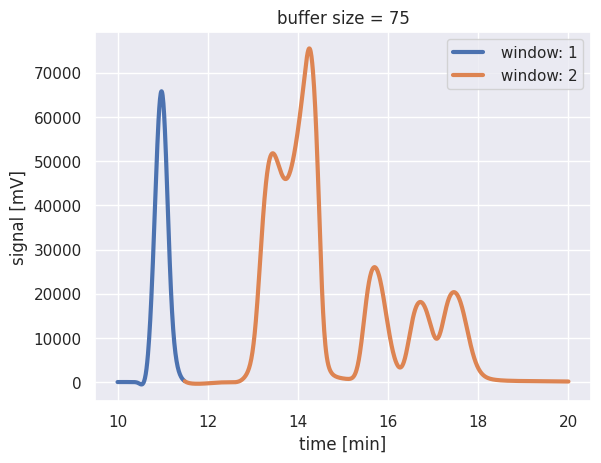

In [20]:
# Increase the buffer and plot the change in the peak window.
buffer = 75
window_df = chrom._assign_windows(prominence=0.01, buffer=buffer)

# Plot each window
for g, d in window_df.groupby('window_id'):
    # Use 'time' and 'signal' instead of 'time_min' and 'intensity_mV'
    plt.plot(d['time'], d['signal'], '-', lw=3, label=f' window: {g}')
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')
plt.title(f'buffer size = {buffer}')
plt.legend()

Note that increasing the buffer size expanded the extent of the orange window by half a minute or so.

Once the chromatogram is clipped into peak windows, each window is passed to an inference stage where the peak mixture is inferred.

The real meat of the package comes in the deconvolution of signal into discrete peaks and measurement of their properties. This typically involves the automated estimation and subtraction of the baseline, detection of peaks, and fitting of skew-normal distributions to reconstitute the signal. Luckily for you, all of this is done in a single method call Chromatogram.fit_peaks()

In [21]:
# Automatically detect and fit the peaks
peaks = chrom.fit_peaks(buffer=0)
peaks

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


,retention_time,scale,skew,amplitude,area,signal_maximum,peak_id
0,10.90,0.158768,0.691959,23380.386568,2.805646e+06,66064.360632,1
0,13.17,0.594721,3.905474,43163.899473,5.179668e+06,50341.309156,2
0,14.45,0.349615,-2.995742,34698.949082,4.163874e+06,65264.917559,3
0,15.53,0.313999,1.621137,15061.414973,1.807370e+06,26771.463047,4
0,16.52,0.347276,1.990206,10936.994296,1.312439e+06,18651.421490,5
0,17.29,0.348001,1.703716,12525.283302,1.503034e+06,20381.895620,6


To see how well the deconvolution worked, you can once again call the show method to see the composite compound chromatograms.

[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

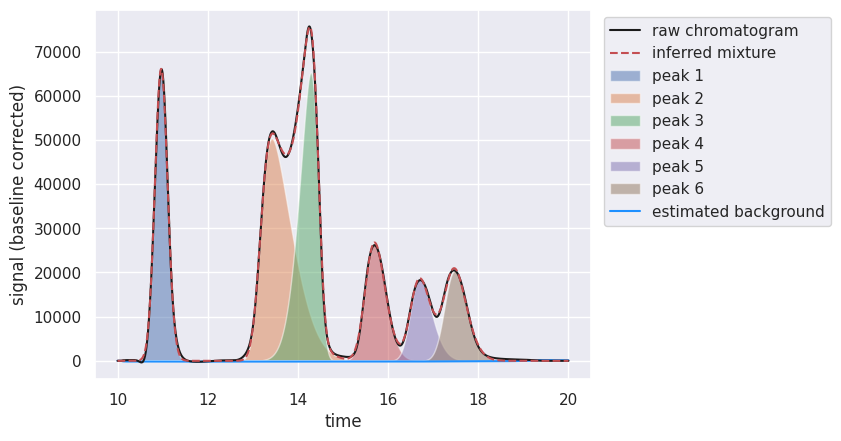

In [22]:
# View the result of the fitting.
chrom.show()

You can also call assess_fit() to see how well the chromatogram is described by the inferred mixture. This is done through computing a reconstruction score
 defined as

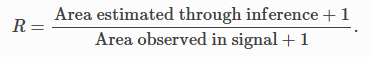

This is computed for regions with peaks (termed “peak windows”) and regions of background (termed “interpeak windows”) if they are present.

In [23]:
# Print out the assessment statistics.
scores = chrom.assess_fit()
scores.head()


-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 10.558 - 11.758) R-Score = 0.9984
A+, Success:  Peak Window 2 (t: 12.117 - 19.817) R-Score = 0.9952

Signal Reconstruction of Interpeak Windows
                  
C-, Needs Review:  Interpeak Window 1 (t: 10.000 - 10.550) R-Score = 0.3902 & Fano Ratio = 0.0024
Interpeak window 1 is not well reconstructed by mixture, but has a small Fano factor
compared to peak region(s). This is likely acceptable, but visually check this region.

C-, Needs Review:  Interpeak Window 2 (t: 11.767 - 12.108) R-Score = 10^-3 & Fano Ratio = 0.0012
Interpeak window 2 is not well reconstructed by mixture, but has a small Fano factor
compared to peak region(s). This is likely acceptable, but visually check this region.

C-, Needs Review:  Interpeak Window 3 (t: 19.825 - 20.000) R-Score = 10^-1 & Fano Ratio = 0.0000
Interpeak window 3 is not well reconstructed by mixture, bu

,window_id,time_start,time_end,signal_area,inferred_area,signal_variance,signal_mean,signal_fano_factor,reconstruction_score,window_type,applied_tolerance,status
0,1,10.00000,10.55000,9.112041e+03,3.555093e+03,8.564681e+03,135.985685,62.982224,0.390153,interpeak,0.01,needs review
1,2,11.76667,12.10833,5.779000e+03,1.155479e+00,4.298102e+03,137.571429,31.242694,0.000200,interpeak,0.01,needs review
2,3,19.82500,20.00000,1.177637e+01,1.000001e+00,2.048615e-01,0.489835,0.418226,0.084916,interpeak,0.01,needs review
0,1,10.55833,11.75833,2.810059e+06,2.805647e+06,5.279468e+08,19379.710827,27242.244966,0.998430,peak,0.01,valid
1,2,12.11667,19.81667,1.403344e+07,1.396639e+07,3.854511e+08,15171.281774,25406.628617,0.995222,peak,0.01,valid


# 3. Quantifying Peaks

If you know the parameters of the linear calibration curve, which relates peak area to a known concentration, you can use the map_compounds method which will map user provided compound names to peaks.

In [24]:
# Define the two peaks of interest and their calibration curves
calibration = {'compound A': {'retention_time': 15.5,
                              'slope': 10547.6,
                              'intercept': -205.6,
                              'unit': 'µM'},
               'compound B': {'retention_time': 17.2,
                              'slope': 26401.2,
                              'intercept': 54.2,
                              'unit': 'nM'}}
quant_peaks = chrom.map_peaks(calibration)
quant_peaks

,retention_time,scale,skew,amplitude,area,signal_maximum,peak_id,compound,concentration,unit
0,15.53,0.313999,1.621137,15061.414973,1.807370e+06,26771.463047,4,compound A,171.373146,µM
0,17.29,0.348001,1.703716,12525.283302,1.503034e+06,20381.895620,6,compound B,56.928465,nM


Successfully mapping compounds to peak ID’s will also be reflected in the show method.


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

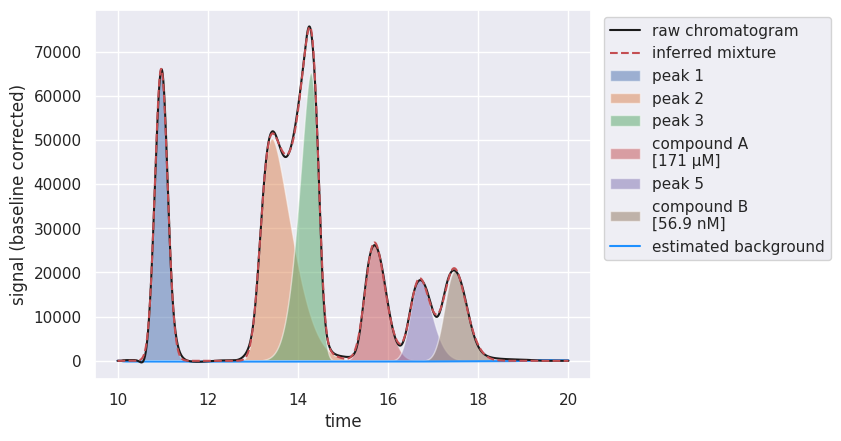

In [25]:
# Show the chromatogram with mapped compounds
chrom.show()

# 4. Deconvolving Overlapping and Subtle Peaks

Often, compounds will have similar retention times leading to heavily overlapping peaks. If one of the compounds dominates the signal, the other compounds may only show up as a “shoulder” on the predominant peak. In this case, automatic peak detection will fail and will fit only a single peak, as in the following example.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

F, Failed:  Peak Window 1 (t: 2.230 - 20.430) R-Score = 0.9788
Peak mixture poorly reconstructs signal. You many need to adjust parameter bounds
or add manual peak positions (if you have a shouldered pair, for example). If
you have a very noisy signal, you may need to increase the reconstruction
tolerance `rtol`.

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 2.220) R-Score = 0.9952 & Fano Ratio = 10^-5
C-, Needs Review:  Interpeak Window 2 (t: 20.440 - 24.990) R-Score = 1.6283 & Fano Ratio = 10^-5
Interpeak window 2 is not well reconstructed by mixture, but has a small Fano factor
compared to peak region(s). This is likely acceptable, but visually check this region.


--------------------------------------------------------------------------------


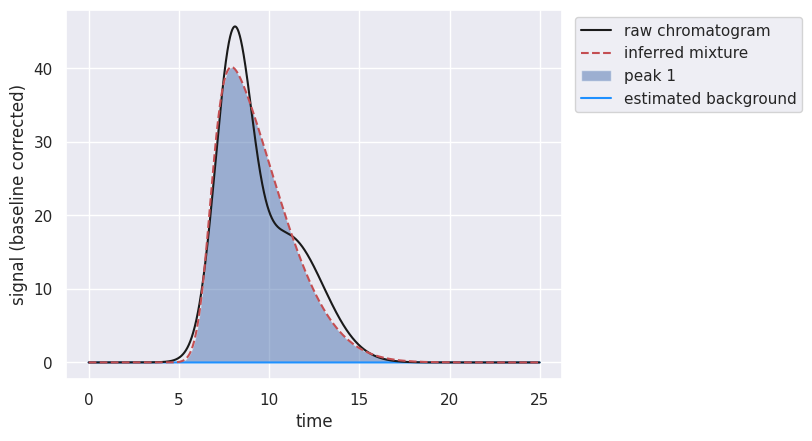

In [27]:
# Load, fit, and display a chromatogram with heavily overlapping peaks
df = load_chromatogram('/content/example_overlap.txt', cols=['time', 'signal'])
chrom = Chromatogram(df)
peaks = chrom.fit_peaks()
chrom.show()
score = chrom.assess_fit()

However, if you know there is a second peak, and you know its approximate retention time, you can manually add an approximate peak position, forcing the algorithm to estimate the peak convolution including more than one peak.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 2.230 - 20.430) R-Score = 1.0000

Signal Reconstruction of Interpeak Windows
                  
C-, Needs Review:  Interpeak Window 1 (t: 0.000 - 2.220) R-Score = 1.0442 & Fano Ratio = 10^-5
Interpeak window 1 is not well reconstructed by mixture, but has a small Fano factor
compared to peak region(s). This is likely acceptable, but visually check this region.

A+, Success:  Interpeak Window 2 (t: 20.440 - 24.990) R-Score = 1.0077 & Fano Ratio = 10^-5

--------------------------------------------------------------------------------


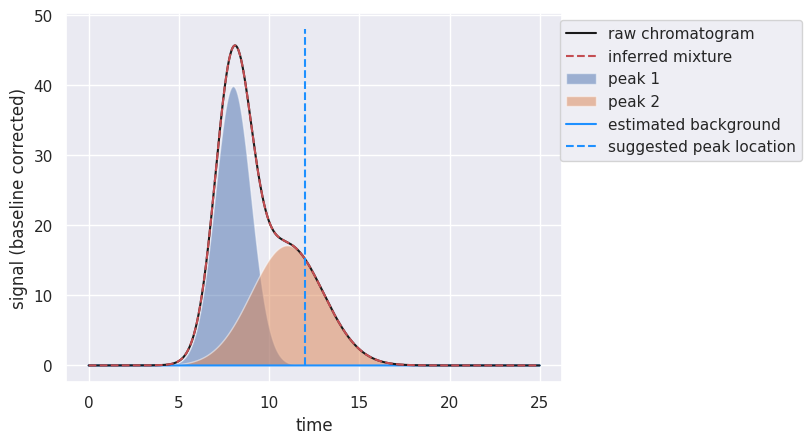

In [28]:
# Enforce a manual peak position at around 11 time units
peaks = chrom.fit_peaks(known_peaks=[12])
chrom.show()
score = chrom.assess_fit()

Note that even though we provided a guess of ≈ 12 time units for the position of the second peak, the algorithm did not force the peak to be exactly there. If enforced_locations are provided, these are used as initial guesses when performing the fitting.

This approach can also be used if there is a shallow, isolated peak that is not automatically detected.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 3.530 - 16.460) R-Score = 1.0000

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 3.520) R-Score = 1.0000 & Fano Ratio = 0
F, Failed:  Interpeak Window 2 (t: 16.470 - 79.990) R-Score = 10^-2 & Fano Ratio = 0.0382
Interpeak window 2 is not well reconstructed by mixture and has an appreciable Fano
factor compared to peak region(s). This suggests you have missed a peak in this
region. Consider adding manual peak positioning by passing `known_peaks`
to `fit_peaks()`.

--------------------------------------------------------------------------------


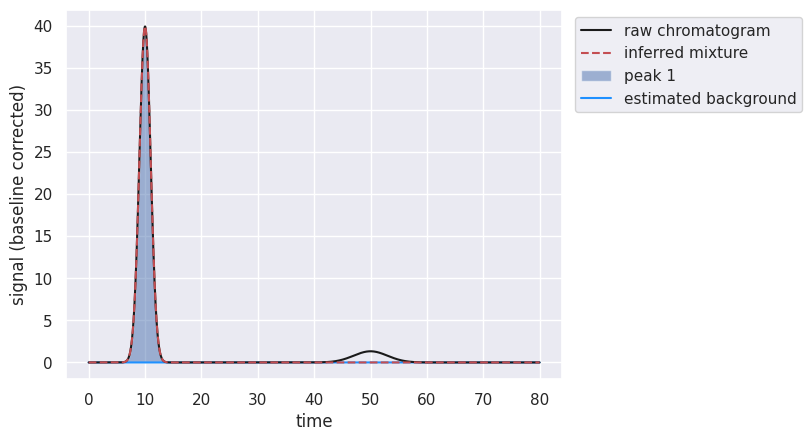

In [30]:
# Load and fit a sample with a shallow peak
df = load_chromatogram('/content/example_shallow.csv', cols=['time', 'signal'])
chrom = Chromatogram(df)
peaks = chrom.fit_peaks(prominence=0.5) # Prominence is to exclude shallow peak
chrom.show()
score = chrom.assess_fit()

As the second peak is broad, you can provide an estimate of the width of the peak at the half maximum value to provide a better initial guess.

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 3.530 - 16.460) R-Score = 1.0000
F, Failed:  Peak Window 2 (t: 45.000 - 54.990) R-Score = 1.1050
Peak mixture poorly reconstructs signal. You many need to adjust parameter bounds
or add manual peak positions (if you have a shouldered pair, for example). If
you have a very noisy signal, you may need to increase the reconstruction
tolerance `rtol`.

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 3.520) R-Score = 1.0000 & Fano Ratio = 0
F, Failed:  Interpeak Window 2 (t: 16.470 - 44.990) R-Score = 1.0151 & Fano Ratio = 0.0160
Interpeak window 2 is not well reconstructed by mixture and has an appreciable Fano
factor compared to peak region(s). This suggests you have missed a peak in this
region. Consider adding manual peak positioning by passing `known_peaks`
to `fit_peaks()`.
A+, Success:  In

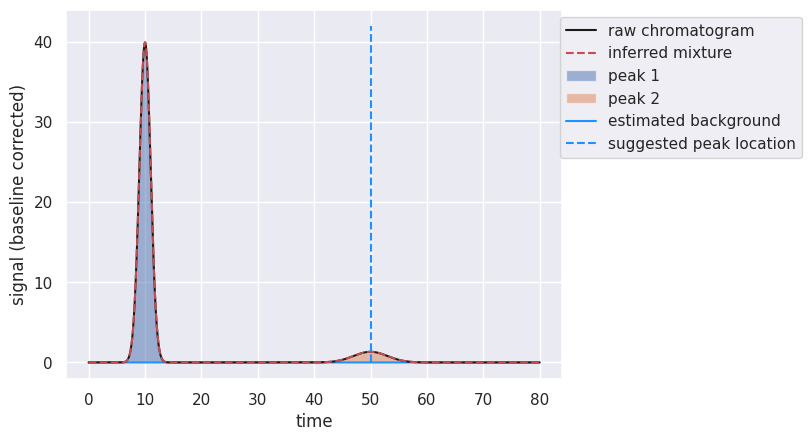

In [31]:
# Add the location of the second peak
peaks = chrom.fit_peaks(known_peaks={50 : {'width': 5}}, prominence=0.5)
chrom.show()
score = chrom.assess_fit()

# 5. Constraining Peaks With Known Parameters

If you have a chromatogram with two completely overlapping peaks, it can be very, very difficult to deconvolve the mixture. However, if you happen to know the parameters of one of the constituents (say, from characterization of an isolated aqueous mixture of that compound), you can apply more stringent bounds to that particular peak. Say for example we have a mixture of two compounds with retention times of 10 and 10.6 and you know that the first peak has an amplitude of 100 units. If you were to only supply the locations of the known peaks, you would underestimate the contribution from the first peak.

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

Inferred amplitude for peak 1 is 94.971. Known value is 100.000


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

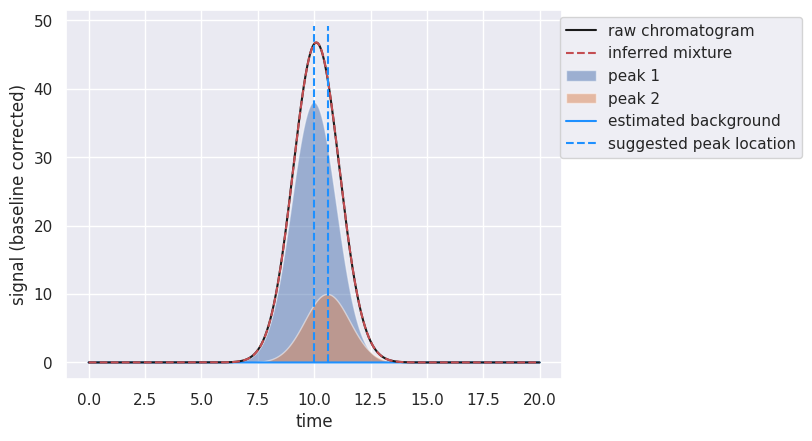

In [33]:
# Load a chromatogram that is very heavily overlapping
df = load_chromatogram('/content/bounding_example.csv', cols=['time', 'signal'])
chrom = Chromatogram(df)

# Fit the peaks providing only the known retention times
peaks = chrom.fit_peaks(known_peaks = [10, 10.6])
inferred_amplitude = peaks[peaks['peak_id']==1]['amplitude'].values[0]
known_amplitude = 100

# Print a summary statement demonstrating the underestimation
print(f'Inferred amplitude for peak 1 is {inferred_amplitude:0.3f}. Known value is {known_amplitude:0.3f}')
chrom.show()

You can constrain the parameter bounds for the amplitude of peak 1 more narrowly than the other peak by passing a dictionary to the known_peaks parameter of fit_peaks().

Deconvolving mixture: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]

Inferred amplitude for peak 1 is 99.000. Known value is 100.000


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

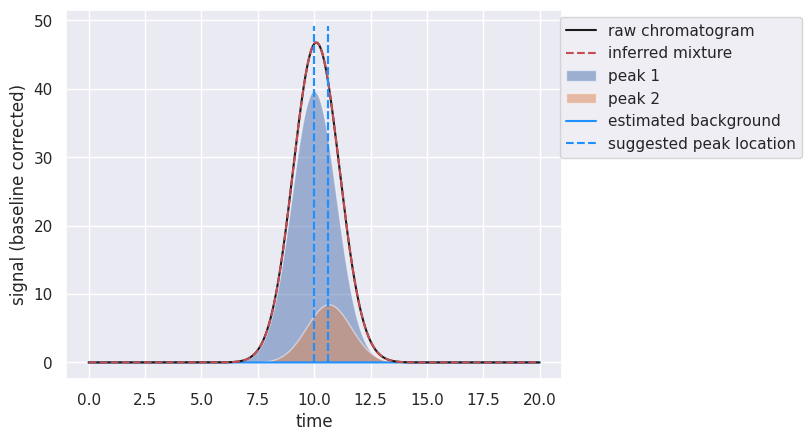

In [34]:
# Define more stringent bounds as a dictionary with the retention time as the key
# and the parameter bounds as a value.
bounds = {10: {'amplitude':[99, 101]}, # Known parameters for peak 1
          10.6 : {} # Allow free inference for second peak
          }
peaks = chrom.fit_peaks(known_peaks=bounds)
inferred_amplitude = peaks[peaks['peak_id']==1]['amplitude'].values[0]

# Print a summary statement demonstrating the improvement.
print(f'Inferred amplitude for peak 1 is {inferred_amplitude:0.3f}. Known value is {known_amplitude:0.3f}')
chrom.show()

Here, we’ve only bounded the amplitude parameter, but you can also provide bounds for location, scale, and skew.



# 7. Absolute Quantitation

A common goal in chromatography is to quantify with physically meaningful units the concentration of an analyte in a solution. While Chromatography will not give that to you directly off the instrument, you can prepare a “standard curve”–a set of solutions where you know the concentration of the analyte of interest. With a properly configured machine, one can make a direct linear relation between the integrated area of a peak and the concentration of the analyte. In this tutorial, we will use hplc-py to quantify a standard curve of a lactose solution and then use the .map_peaks method of the Chromatogram object to test our calibration curve.

##Generating a Calibration Curve

Here, we will use hplc-py to quantify aqueous solutions of lactose in different concentrations. These files have been preprocessed to have the known lactose concentration in the file name.

In [35]:
# Download the specific calibration file
!wget https://raw.githubusercontent.com/cremerlab/hplc-py/main/docs/source/tutorials/data/calibration/lactose_mM_6.csv

import glob

# Set the files list to the downloaded file
files = ['lactose_mM_6.csv']
print(files[0])

--2025-11-26 10:42:15--  https://raw.githubusercontent.com/cremerlab/hplc-py/main/docs/source/tutorials/data/calibration/lactose_mM_6.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7469 (7.3K) [text/plain]
Saving to: ‘lactose_mM_6.csv’

lactose_mM_6.csv    100%[===================>]   7.29K  --.-KB/s    in 0s      

2025-11-26 10:42:15 (95.2 MB/s) - ‘lactose_mM_6.csv’ saved [7469/7469]

lactose_mM_6.csv


We can load this file into memory as a chromatogram using the load_chromatogram function from the io module and instantiate a Chromatogram object.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

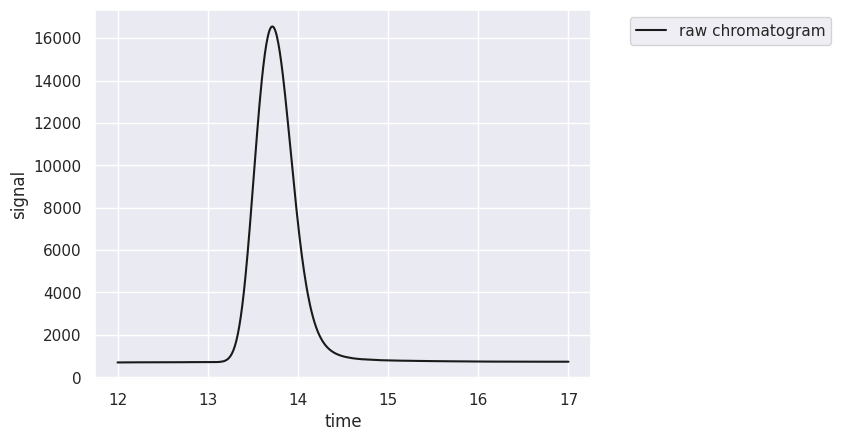

In [36]:
from hplc.io import load_chromatogram
from hplc.quant import Chromatogram

# Load and display the first file.
df = load_chromatogram(files[0], cols=['time', 'signal'])
chrom = Chromatogram(df)
chrom.show()

As a reminder, we can quickly quantify this single peak by calling the .fit_peaks method.

,retention_time,scale,skew,amplitude,area,signal_maximum,peak_id
0,13.56,0.281228,1.654595,8004.240816,960508.897898,15977.970977,1


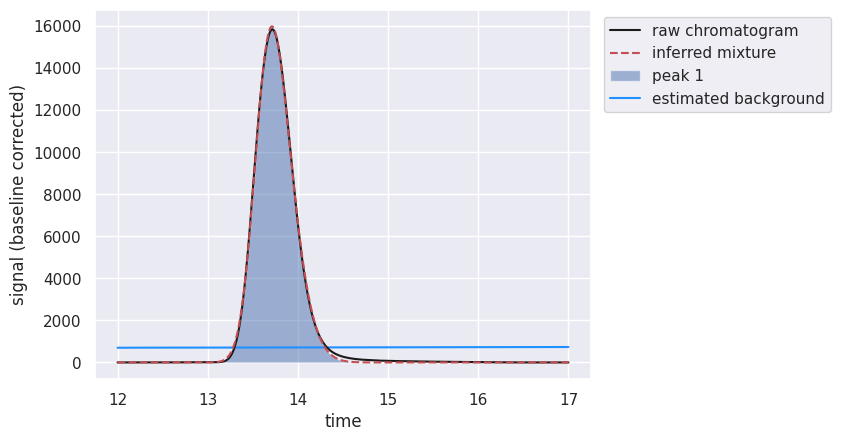

In [37]:
# Quantify the peak
peaks = chrom.fit_peaks(verbose=False)
chrom.show()
peaks.head()

While it’s useful to know the various parameters returned by the fitting, we are interested in the integrated area of the peak (integrated over the entire duration of the chromatogram). Using a for loop and getting the concentration of lactose from each file name, we can generate a new Pandas DataFrame which will hold the calibration information.

In [38]:
import glob
import shutil
import os

# Clone the repository to a temporary directory
!git clone https://github.com/cremerlab/hplc-py.git temp_repo

# Define the source path for the calibration files
source_dir = 'temp_repo/docs/source/tutorials/data/calibration'

# Copy the desired CSV files to the current directory
# We look for files matching the pattern in the cloned repo
for file_path in glob.glob(os.path.join(source_dir, 'lactose_mM_*.csv')):
    shutil.copy(file_path, '.')

# Remove the temporary repository
shutil.rmtree('temp_repo')

# Get a list of all lactose calibration csv files
files = glob.glob('lactose_mM_*.csv')
files.sort()
print("Retrieved files:", files)

Cloning into 'temp_repo'...
remote: Enumerating objects: 1792, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 1792 (delta 227), reused 301 (delta 206), pack-reused 1407 (from 1)
Receiving objects: 100% (1792/1792), 42.88 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (853/853), done.
Retrieved files: ['lactose_mM_0.5.csv', 'lactose_mM_1.csv', 'lactose_mM_3.csv', 'lactose_mM_6.csv']


In [39]:
import pandas as pd
# Set up a blank dataframe for the calibration curve.
cal_curve = pd.DataFrame([])

# Iterate through each file and perform the quantitation
for f in files:
    df = load_chromatogram(f, cols=['time', 'signal'])
    chrom = Chromatogram(df)
    peaks = chrom.fit_peaks(verbose=False)

    # Get the concentration of lactose from the file name
    conc = float(f.split('_')[-1][:-4])

    # Add the concentration to the peak table and add it
    # to the instantiated calibration dataframe
    peaks['conc_mM'] = conc
    cal_curve = pd.concat([cal_curve, peaks])

cal_curve

,retention_time,scale,skew,amplitude,area,signal_maximum,peak_id,conc_mM
0,13.56,0.278886,1.627672,747.107260,89652.871210,1496.949321,1,0.5
0,13.56,0.278874,1.629961,1540.315414,184837.849641,3087.620065,1,1.0
0,13.56,0.280349,1.644179,3896.489630,467578.755572,7787.982871,1,3.0
0,13.56,0.281228,1.654595,8004.240816,960508.897898,15977.970977,1,6.0


We can now plot the peak area as a function of time, which we expect to appear linear.

Text(0, 0.5, 'integrated peak area [a.u.]')

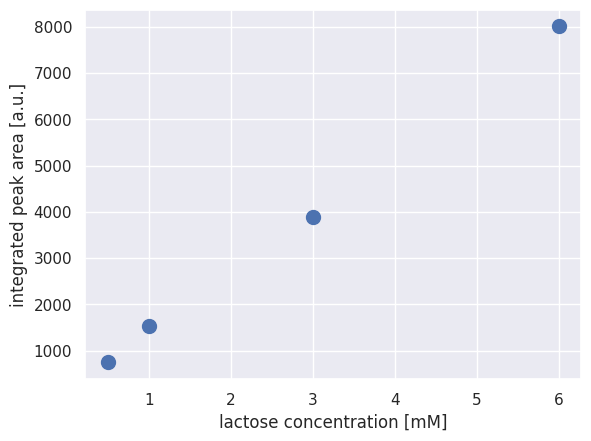

In [40]:
import matplotlib.pyplot as plt

# Plot the calibration curve.
plt.plot(cal_curve['conc_mM'], cal_curve['amplitude'], 'o', markersize=10)
plt.xlabel('lactose concentration [mM]')
plt.ylabel('integrated peak area [a.u.]')


We can perform a simple regression on these data to get a calibration curve.

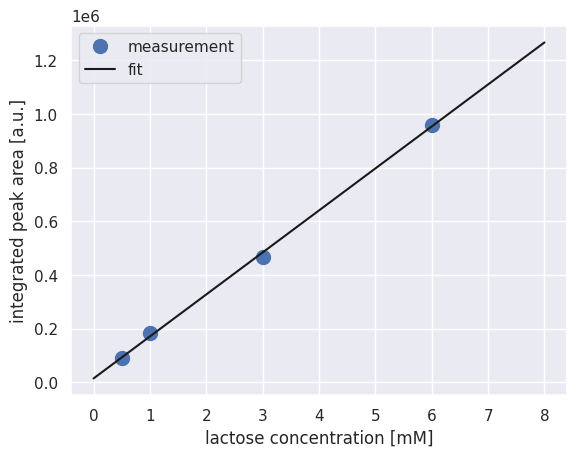

In [41]:
import numpy as np
from scipy.stats import linregress

#  Compute the best fit calibration curve
fit_params = linregress(cal_curve['conc_mM'], cal_curve['area'])
slope = fit_params[0]
intercept = fit_params[1]

# Plot the fit over the data
conc_range = np.linspace(0, 8, 100)
cal = intercept + slope * conc_range
plt.plot(cal_curve['conc_mM'], cal_curve['area'], 'o', markersize=10, label='measurement')
plt.plot(conc_range, cal, '-', color='k', label='fit')
plt.xlabel('lactose concentration [mM]')
plt.ylabel('integrated peak area [a.u.]')
plt.legend()

## Testing the Calibration

We also have a set of lactose solutions with known concentrations that we did not use when fitting the calibration curve. We can use the .map_peaks method when quantifying these test data to see if we get the same concentrations out that we know the peaks represent.

In [42]:
# Load the test data
# Corrected path: files are in the current directory
files = glob.glob('lactose_mM_*.csv')

# Instantiate a dataframe to store the results
test_data = pd.DataFrame([])

# Iterate through each file and quantify the peaks
for f in files:
    df = load_chromatogram(f, cols=['time', 'signal'])
    chrom = Chromatogram(df)
    peaks =  chrom.fit_peaks(verbose=False)

    # Now, use the map_peaks method to quantify the signal based off our
    # calibration curve
    mapping = {'lactose': {'retention_time': 13.56,
                           'slope': slope,
                           'intercept': intercept,
                           'unit': 'mM'}}
    measured_conc = chrom.map_peaks(params=mapping)

    # Parse the known concentration from the file name
    known_conc = float(f.split('_')[-1][:-4])

    # Add it to the dataframe and concatenate
    measured_conc['true_conc_mM']  = known_conc
    test_data  = pd.concat([test_data, measured_conc])
test_data

,retention_time,scale,skew,amplitude,area,signal_maximum,peak_id,compound,concentration,unit,true_conc_mM
0,13.56,0.278874,1.629961,1540.315414,184837.849641,3087.620065,1,lactose,1.087136,mM,1.0
0,13.56,0.278886,1.627672,747.107260,89652.871210,1496.949321,1,lactose,0.479256,mM,0.5
0,13.56,0.281228,1.654595,8004.240816,960508.897898,15977.970977,1,lactose,6.040804,mM,6.0
0,13.56,0.280349,1.644179,3896.489630,467578.755572,7787.982871,1,lactose,2.892804,mM,3.0


It looks like it's in good agreement! We can confirm this by plotting the measured value versus the true value. If in agreement, everything should fall on the identity line.

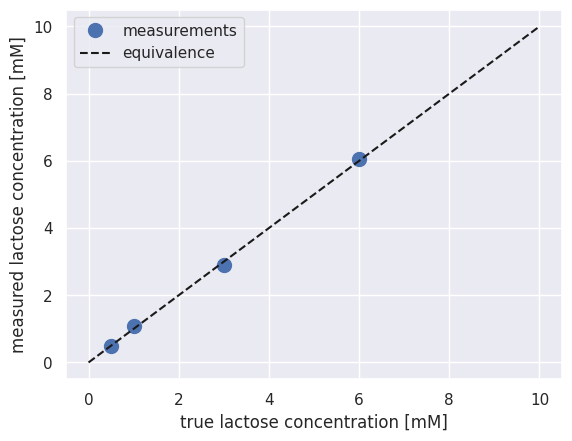

In [43]:
# Plot the measured versus known value of the test set
plt.plot(test_data['true_conc_mM'], test_data['concentration'], 'o',
         markersize=10, label='measurements')
plt.plot([0, 10], [0, 10], 'k--', label='equivalence')
plt.xlabel('true lactose concentration [mM]')
plt.ylabel('measured lactose concentration [mM]')
plt.legend()
